[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/andreofner/pyGPC/blob/master/demo.ipynb)

/Users/andre/PycharmProjects/BrainAI/venv/lib/python3.9/site-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


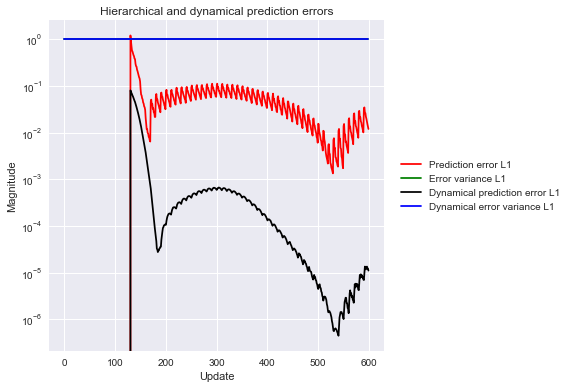

In [1]:
"""
Generalized predictive coding
Circles dataset
"""

import matplotlib.pyplot as plt
import torch
import math
import numpy as np
import IPython
import MovingMNIST as MovingMNIST
from model_circles import *
from circles_dataset import *

train_set = torch.from_numpy(get_dataset(get_dataset_args())['x']).transpose(0,1)

# hierarchical net
GEN_COORDS = 6
cause_sizes = [1, 0]
hidden_sizes = [0, 32]
net = GPC_net(b_size=BATCH_SIZE, dynamical_net=False,
              cause_sizes=cause_sizes, hidden_sizes=hidden_sizes,
              gen_coords=GEN_COORDS)

# logging and visualization
errors, cov_h, errors_d1, errors_d2, errors_d3, cov_d1, cov_d2, cov_d3 = [[] for _ in range(8)]
err_g1, err_g2, err_g3, cov_g1, cov_g2, cov_g3 = [[] for _ in range(6)]
err_h1, err_h2, err_h3 = [], [], []
colors, lines = ["black", "yellow", "orange", "red", "brown", "purple"], []

INTERPOLATE = False
INTERPOLATION_START = 60
INTERPOLATION_END = INTERPOLATION_START + GEN_COORDS-1
INTERPOLATION_EPOCH = 0
FINAL_EPOCH = 1

for epoch in range(FINAL_EPOCH):
    train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                               batch_size=BATCH_SIZE, shuffle=False)
    for seq_id, seq in enumerate(train_loader):
        vid_in, vid_p1, vid_p2, vid_p3, vid_p4 = [], [], [], [], []
        vid_gc_cause, vid_gc_hidden = [], []
        vid_cause_coords, vid_gc_pred, vid_cause_coords_input = [], [], []

        seq = torch.transpose(seq, 0,1)
        if seq_id == INTERPOLATION_EPOCH and epoch == FINAL_EPOCH-1:
            INTERPOLATE = True
        for id, data in enumerate(seq):
            data = data/2

            if True:
                data = data[:,:1] # observe only one dimension

            VIDEO = False
            if (id < INTERPOLATION_START): # optimize
                for update in range(UPDATES):

                    # step hierarchical net
                    if id > GEN_COORDS * 2: # give the sensory layer some time to adjust at the start
                        # step dynamical nets
                        eg1, eh1, ed1, cg1, cd1 = net.layers[1].dyn_model.iterative_inference(updates=1, predict_hierarchical=False)
                        e, _, _, ch, _ = net.iterative_inference(data, updates=1)

                        # plot inference for a single datapoint
                        if False and id == INTERPOLATION_START-1:
                            state = net.layers[1].dyn_model.layers[0].states.hidd_state.detach()
                            pred_change = net.layers[1].dyn_model.nets_d[0](state).detach()
                            encoded_change = net.layers[1].dyn_model.layers[1].states.hidd_state.detach()
                            l1 = plt.scatter(update, state[0,0].mean(), color="black", label="x State", alpha=(epoch+1)/FINAL_EPOCH)
                            l2 = plt.scatter(update, pred_change[0,0].mean(), color="green", label="f(x) Pred change", alpha=(epoch+1)/FINAL_EPOCH)
                            l3 = plt.scatter(update, encoded_change[0,0].mean(), color="blue", label="x' Encoded change", alpha=(epoch+1)/FINAL_EPOCH)

                    else:
                        eg1, eh1, ed1, cg1, cd1 = [0.], [0.], [0.], [1.], [1.]
                        e, ch = [[0.]], [[1.]]

                    errors, cov_h = errors + e, cov_h + ch
                    errors_d1, cov_d1 = errors_d1 + ed1, cov_d1 + cd1
                    err_g1, cov_g1 = err_g1 + eg1, cov_g1 + cg1
                    err_h1 = err_h1+eh1;

                # step dynamical nets
                _, _, _, _, _ = net.layers[0].dyn_model.iterative_inference(data, updates=2)

                for layer in net.layers:
                    layer.dyn_model.state_diff(step=True) # move current to previous state

                # log encoded inputs in generalized coordinates
                cause_coords = [l.states.cause_state.detach().numpy()[...,0,:] for l in net.layers[0].dyn_model.layers]
                vid_cause_coords_input.append(np.asarray(cause_coords))

                VIDEO = True
            elif INTERPOLATE:
                """
                There are three types of dynamical predictions in generalized predictive coding:
                a) A state and its encoded motion [x,x',x'',..] - the locally observed trajectory of a state x:
                    Mapping from generalized states to local discrete trajectory via generalized coordinates of state motion
                b) Predicted motion [w(x)->f(x'), w'(x')->f(x''), ...] - the learned dynamics of a generalized state:
                    Mapping from generalized states to their predicted motion via dynamical weights
                c) Hierarchical predictions w_l(v_l,x_l)->x_(l-1):
                    Sequences of sequences of ...
                """

                time = id-INTERPOLATION_START+1 # track time since last observation

                """ a) Visualize encoded local sensory trajectory"""
                # extrapolate encoded input in gen. coordinates
                cause_coords = net.layers[0].dyn_model.decode_dynamical_cause(t=time)
                vid_cause_coords.append(cause_coords)

                """ a) Visualize the motion of predicted local trajectory: The sensory trajectory encoded by a latent state"""
                net.layers[1].dyn_model.decode_dynamical_hidden(t=time) # decode the predicted state motion

                """ b) Visualize the dynamical prediction: The latent trajectory encoded by dynamical weights"""

                """ b) Visualize the hierarchical prediction: Top-down predicted sequences of generalized states """

                VIDEO = True

            # create video
            if VIDEO:
                input, preds = plot_2D(net=net, img_size=IMG_SIZE, plot=False)
                input = data.detach()[0]
                vid_in.append(input.detach().numpy().reshape([IMG_SIZE]))
                vid_p1.append(preds[0][0][0].reshape([IMG_SIZE])) # 1st predicted gen coord
                vid_p2.append(preds[0][1][0].reshape([IMG_SIZE])) # 2nd predicted gen coord
                vid_p3.append(preds[0][2][0].reshape([IMG_SIZE])) # 3rd predicted gen coord

                state_coords = net.layers[0].dyn_model.layers[1].lower.states.cause_state[0].detach().numpy()
                hidd_coords = net.layers[0].dyn_model.layers[1].lower.states.hidd_state[0].detach().numpy()
                vid_gc_cause.append(state_coords)
                vid_gc_hidden.append(hidd_coords)

            if id == INTERPOLATION_END: break
        if seq_id == INTERPOLATION_EPOCH: break
#plt.legend(handles=[l1,l2,l3])
plt.show()

""" Losses """
if True:
    plot_graph(errors, errors_d1, errors_d2, errors_d3, cov_d1, cov_d2, cov_d3,cov_g1,
               cov_g2, cov_g3, err_g1, err_g2, err_g3, err_h1, err_h2, err_h3, cov_h,
               hierarchical=True, g_coords=False, dynamical=True)


Learned generalized coordinates of sensory inputs in the first (sensory) layer:


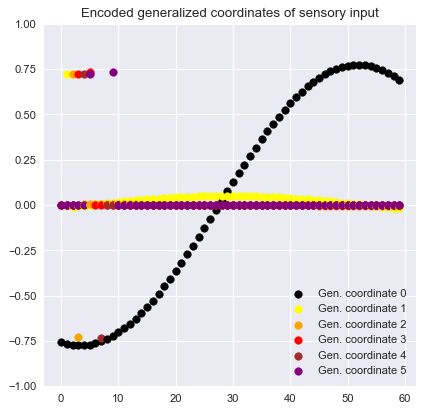

Extrapolating the inferred generalized coordinates in the first (sensory) layer:


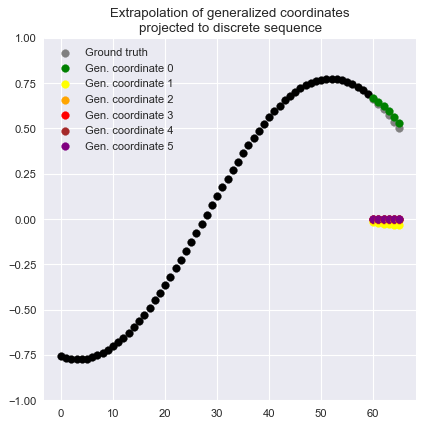

Learned generalized coordinates of latent states in the second (hidden) layer mapped to sensory predictions:


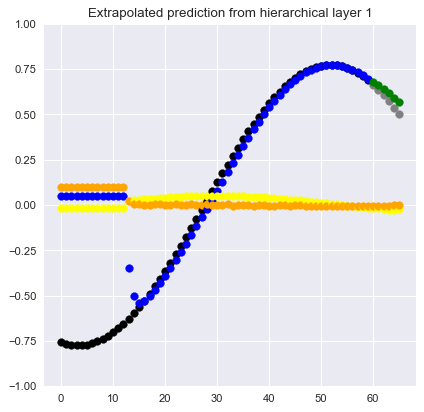

Note that we have to wait a bit until the sensory layer has enough context to correctly encode the discrete sequence in generalized coordinates
The sensory layer operates causally (i.e. no information from the future is encoded). We could generate more accurate sensory encodings with a slight delay of n samples, where n is the order of generalized coordinates. However, the higher the sampling rate, the smaller this effect.


In [4]:
""" Hierarchical predictions """
# plot settings
GC_TIME = False # align higher order generalized coordinates to a time axis

print("Learned generalized coordinates of sensory inputs in the first (sensory) layer:")
""" Encoded generalized coordinates of input """
plt.figure(figsize=(6, 6), dpi=80)
for t, inp in enumerate(vid_cause_coords_input):
    colors, lines = ["black", "yellow", "orange", "red", "brown", "purple"], []
    for gc in range(len(vid_cause_coords_input[t])):
        select = 0 if GC_TIME else gc
        lines.append(plt.scatter(t, # vid_cause_coords_input[t][select][0]
                    vid_cause_coords_input[t][gc][0], color=colors[gc], label=f"Gen. coordinate {gc}"))
plt.title("Encoded generalized coordinates of sensory input")
plt.legend(handles=lines)
plt.ylim(-1,1)
plt.show()

print("Extrapolating the inferred generalized coordinates in the first (sensory) layer:")
""" Extrapolated encoded generalized coordinates of input """
plt.figure(figsize=(6, 6), dpi=80)
for t, inp in enumerate(vid_in):
    if t < INTERPOLATION_START:
        l0 = plt.scatter(t, inp[0], color="black", label="Ground truth (burn in)")
    else:
        colors, lines = ["green", "yellow", "orange", "red", "brown", "purple"], []
        lines.append(plt.scatter(t, inp[0], color="grey", label="Ground truth"))
        for gc in range(len(vid_cause_coords[t-INTERPOLATION_START])):
            select = 0 if GC_TIME else gc
            lines.append(plt.scatter(t, #vid_cause_coords[t-INTERPOLATION_START][select][0]
                        vid_cause_coords[t-INTERPOLATION_START][gc][0],
                        color=colors[gc], label=f"Gen. coordinate {gc}"))
plt.title("Extrapolation of generalized coordinates\nprojected to discrete sequence")
plt.legend(handles=lines)
plt.ylim(-1,1)
plt.show()

print("Learned generalized coordinates of latent states in the second (hidden) layer mapped to sensory predictions:")
plt.figure(figsize=(6, 6), dpi=80)
for t, (inp, pred, pred1, pred2) in enumerate(zip(vid_in, vid_p1, vid_p2, vid_p3)):
    colors, lines = ["green", "yellow", "orange", "red", "brown", "purple"], []
    if GC_TIME:
        pred[0] = pred1[0] = pred2[0] = inp[0]
    if t < INTERPOLATION_START:
        plt.scatter(t, inp[0], color="black")
        plt.scatter(t, pred[0], color="blue")
        plt.scatter(t, pred1[0], color=colors[1])
        plt.scatter(t, pred2[0], color=colors[2])
    else:
        plt.scatter(t, inp[0], color="grey")
        plt.scatter(t, pred[0], color="green")
        plt.scatter(t, pred1[0], color=colors[1])
        plt.scatter(t, pred2[0], color=colors[2])
plt.title("Extrapolated prediction from hierarchical layer 1")
plt.ylim(-1,1)
plt.show()

print("Note that we have to wait a bit until the sensory layer has enough context to correctly encode the discrete sequence in generalized coordinates")
print("The sensory layer operates causally (i.e. no information from the future is encoded). We could generate more accurate sensory encodings with a slight delay of n samples, where n is the order of generalized coordinates. However, the higher the sampling rate, the smaller this effect.")
